In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

In [3]:
from IPython.display import display, clear_output
from ipywidgets import (
    interact,
    fixed,
    FloatSlider,
    FloatLogSlider,
    HBox,
    Layout,
    Output,
    VBox,
    GridspecLayout,
    Label
)
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from matplotlib import colors
from scipy.stats import beta as Beta
from scipy.stats import lognorm as LogNormal
from scipy.stats import norm as Normal
import starry
from starry_process.gp import YlmGP

starry.config.lazy = False
starry.config.quiet = True

In [4]:
ydeg = 10
map = starry.Map(ydeg)
map.render();
gp = YlmGP(ydeg)

In [5]:
def slider(minval, maxval, val, step, descr, log=False):
    if log:
        func = FloatLogSlider
        kwargs = {"base": 10}
    else:
        func = FloatSlider
        kwargs = {}
    return func(
        min=minval,
        max=maxval,
        value=val,
        step=step,
        orientation="vertical",
        description=descr,
        continuous_update=False,
        layout=Layout(height="%dpx", width="55px"),
        **kwargs
    )

In [19]:
pl_dist = Output(layout=Layout(width="60%"))
pl_maps = Output(layout=Layout(width="100%"))
pl_cbar = Output(layout=Layout(width="100%"))

sl_mu_lat = slider(0, 1, 0.85, 0.01, r"$\mu$")
sl_nu_lat = slider(-10, 0, 1e-2, 0.1, r"$\nu$", log=True)

sl_mu_s = slider(-3, np.log10(0.3), 0.025, 0.1, r"$\mu$", log=True)
sl_nu_s = slider(-10, 0, 1e-2, 0.1, r"$\nu$", log=True)

sl_mu_a = slider(-10, 0, -2.3, 0.1, r"$\mu$")
sl_nu_a = slider(0, 1, 0.1, 0.01, r"$\nu$")

vmin = 0
vmax = 2 / np.pi
norm = colors.Normalize(vmin=vmin, vmax=vmax)
cmap = plt.get_cmap("plasma")
cmap.set_under("k")
cmap.set_over(cmap(1.0))
with pl_cbar:
    fig, ax = plt.subplots(1, figsize=(12, 0.25))
    ax.imshow(
        np.linspace(vmin, vmax, 1000).reshape(1, -1),
        cmap=cmap,
        norm=norm,
        extent=(0, 1, 0, 1),
        aspect="auto",
    )
    ax.set_yticks([])
    for tick in ax.get_xticklabels():
        tick.set_fontsize(10)
    plt.show()


def update_plot(change=None):

    # Get the current params
    mu_lat = min(max(1e-5, sl_mu_lat.value), 1 - 1e-5)
    nu_lat = min(sl_nu_lat.value, 1 - 1e-5)
    alpha_lat = mu_lat * (1 / nu_lat - 1)
    beta_lat = (1 - mu_lat) * (1 / nu_lat - 1)

    mu_s = min(max(1e-5, sl_mu_s.value), 1 - 1e-5)
    nu_s = min(sl_nu_s.value, 1 - 1e-5)
    alpha_s = mu_s * (1 / nu_s - 1)
    beta_s = (1 - mu_s) * (1 / nu_s - 1)

    mu_a = sl_mu_a.value
    nu_a = sl_nu_a.value

    # Plot the distributions
    with pl_dist:

        # Setup
        clear_output(wait=True)
        fig = plt.figure(figsize=(12, 8))
        fig.subplots_adjust(hspace=0.4)

        # Cos latitude
        ax1 = plt.subplot2grid((3, 2), (0, 0))
        cosphi = np.linspace(0, 1, 1000)
        ax1.plot(cosphi, Beta.pdf(cosphi, alpha_lat, beta_lat))
        ax1.set_xlim(0, 1)
        ax1.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: "%.1f" % x))
        ax1.set_xlabel("cos latitude", fontsize=14)
        ax1.set_yticks([])
        ax1.axvline(mu_lat, color="C1", ls="--", lw=1, label=r"$\mu$")
        std = np.sqrt(nu_lat * mu_lat * (1 - mu_lat))
        ax1.axvspan(mu_lat - std, mu_lat + std, color="C1", alpha=0.5, label=r"$\nu\mu(1-\mu)$")
        for tick in ax1.get_xticklabels():
            tick.set_fontsize(12)
        ax1.legend(loc="upper left", fontsize=10)
        
        # Latitude
        ax2 = plt.subplot2grid((3, 2), (1, 0))
        phi = np.linspace(-90, 90, 1000)
        ax2.plot(
            phi,
            0.5
            * np.abs(np.sin(phi * np.pi / 180))
            * Beta.pdf(np.cos(phi * np.pi / 180), alpha_lat, beta_lat),
        )
        ax2.set_xlim(-90, 90)
        ax2.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: "%.1f" % x))
        ax2.set_xlabel("latitude", fontsize=14)
        ax2.set_yticks([])
        for tick in ax2.get_xticklabels():
            tick.set_fontsize(12)

        # Size
        ax3 = plt.subplot2grid((3, 2), (0, 1))
        s = np.linspace(0, 1, 1000)
        p_of_s = Beta.pdf(s, alpha_s, beta_s)
        ax3.plot(s, p_of_s)
        ax3.set_xlim(0, 0.3)
        ax3.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: "%.1f" % x))
        ax3.set_xlabel("size", fontsize=14)
        ax3.set_yticks([])
        ax3.axvline(mu_s, color="C1", ls="--", lw=1, label=r"$\mu$")
        std = np.sqrt(nu_s * mu_s * (1 - mu_s))
        ax3.axvspan(mu_s - std, mu_s + std, color="C1", alpha=0.5, label=r"$\nu\mu(1-\mu)$")
        for tick in ax3.get_xticklabels():
            tick.set_fontsize(12)
        ax3.legend(loc="upper right", fontsize=10)
        
        # Amplitude
        ax4 = plt.subplot2grid((3, 2), (1, 1))
        lna = np.linspace(-10, 0, 1000)
        ax4.plot(lna, Normal.pdf(lna, mu_a, np.sqrt(nu_a)))
        ax4.set_xlim(-10, 0)
        ax4.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: "%.1f" % x))
        ax4.set_xlabel(r"$\log_{10}$ amplitude", fontsize=14)
        ax4.set_yticks([])
        for tick in ax4.get_xticklabels():
            tick.set_fontsize(12)

        plt.show()

    # Plot the maps
    with pl_maps:

        # Setup
        clear_output(wait=True)
        fig, ax = plt.subplots(1, 5, figsize=(13, 2))
        gp.set_params(mu_lat, nu_lat, mu_s, nu_s, mu_a, nu_a)
        y = np.vstack((gp.mu, gp.draw(4)))
        for k in range(5):
            map[1:, :] = y[k]
            map.show(ax=ax[k], projection="moll", norm=norm, cmap=cmap)

        ax[0].annotate(
            "mean",
            xy=(0.5, 0),
            xycoords="axes fraction",
            xytext=(0, -10),
            textcoords="offset points",
            fontsize=8,
            ha="center",
            va="top",
        )

        plt.show()


sl_mu_lat.observe(update_plot, "value")
sl_nu_lat.observe(update_plot, "value")
sl_mu_s.observe(update_plot, "value")
sl_nu_s.observe(update_plot, "value")
sl_mu_a.observe(update_plot, "value")
sl_nu_a.observe(update_plot, "value")
update_plot()

l_lat = Label(
    value="$\mathrm{latitude}$",
    layout=Layout(
        width="100%",
        display="flex",
        justify_content="center",
        margin="15px 0px 0px 0px",
    ),
)

l_s = Label(
    value="$\mathrm{size}$",
    layout=Layout(
        width="100%",
        display="flex",
        justify_content="center",
        margin="15px 0px 0px 0px",
    ),
)

l_a = Label(
    value="$\log_{10} \mathrm{amp}$",
    layout=Layout(
        width="100%",
        display="flex",
        justify_content="center",
        margin="15px 0px 0px 0px",
    ),
)

grid = VBox(
    [
        HBox(
            [
                pl_dist,
                VBox(
                    [l_lat, HBox([sl_mu_lat, sl_nu_lat])],
                    layout=Layout(border="1px solid", margin="10px 5px 10px 10px"),
                ),
                VBox(
                    [l_s, HBox([sl_mu_s, sl_nu_s])],
                    layout=Layout(border="1px solid", margin="10px 5px 10px 5px"),
                ),
                VBox(
                    [l_a, HBox([sl_mu_a, sl_nu_a])],
                    layout=Layout(border="1px solid", margin="10px 10px 10px 5px"),
                ),
            ]
        ),
        pl_maps,
        pl_cbar,
    ]
)

display(grid)

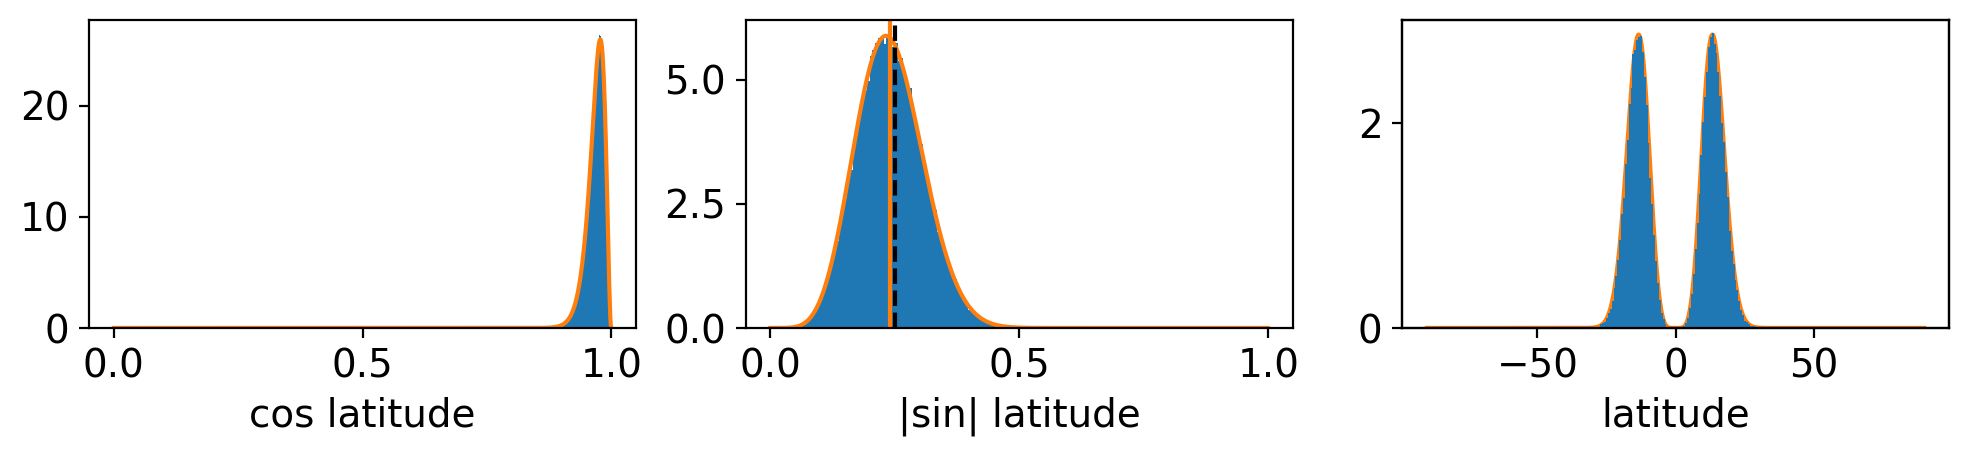

In [7]:
def plot_latitude_distr(mu_lat=0.85, nu_lat=0.01):
    
    
    
    # Transform to Beta params
    mu_c_lat = np.sqrt(1 - mu_lat ** 2)
    alpha_lat = mu_c_lat * (1 / nu_lat - 1)
    beta_lat = (1 - mu_c_lat) * (1 / nu_lat - 1)

    # Sample
    nsamples = 100000
    samples_cos_lat = Beta.rvs(alpha_lat, beta_lat, size=nsamples)
    samples_lat = 180 / np.pi * np.arccos(samples_cos_lat) * 2 * (np.random.randint(0, 2, nsamples) - 0.5)
    samples_sin_lat = np.abs(np.sin(np.pi / 180 * samples_lat))
    
    # Plot
    fig, ax = plt.subplots(1, 3, figsize=(12, 2))

    # Cos latitude
    cos_lat = np.linspace(0, 1, 1000)
    ax[0].hist(samples_cos_lat, density=True, bins=100)
    ax[0].plot(cos_lat, Beta.pdf(cos_lat, alpha_lat, beta_lat))
    ax[0].set_xlabel("cos latitude")

    # Sin latitude
    sin_lat = np.linspace(0, 1, 1000)
    cos_lat = np.sqrt(1 - sin_lat ** 2)
    ax[1].hist(samples_sin_lat, density=True, bins=100)
    ax[1].plot(sin_lat, sin_lat / cos_lat * Beta.pdf(cos_lat, alpha_lat, beta_lat))
    ax[1].set_xlabel("|sin| latitude")
    ax[1].axvline(mu_lat, ls="--", color="k")
    ax[1].axvline(np.mean(samples_sin_lat), color="C1")
    
    # Latitude
    lat = np.linspace(-90, 90, 1000)
    ax2t = ax[2].twinx()
    ax2t.hist(samples_lat, density=True, bins=100)
    ax[2].plot(
        lat,
        0.5
        * np.abs(np.sin(lat * np.pi / 180))
        * Beta.pdf(np.cos(lat * np.pi / 180), alpha_lat, beta_lat),
        color="C1"
    )
    ax2t.set_ylim(0, np.pi / 180 * ax[2].get_ylim()[1])
    ax[2].set_ylim(0, ax[2].get_ylim()[1])
    ax2t.set_zorder(ax[2].get_zorder() + 1)
    ax2t.set_yticks([])
    ax[2].set_xlabel("latitude")
    
plot_latitude_distr(mu_lat=0.25, nu_lat=0.01)